In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Carga de datos climaticos

In [70]:
import openmeteo_requests

import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2023-10-31",
	"end_date": "2024-01-01",
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s
                          date  temperature_2m  relative_humidity_2m  rain  \
0    2023-10-31 04:00:00+00:00         10.0225             63.106869   0.0   
1    2023-10-31 05:00:00+00:00          9.6725             62.580620   0.0   
2    2023-10-31 06:00:00+00:00          9.1725             63.132240   0.0   
3    2023-10-31 07:00:00+00:00          8.9225             63.977451   0.0   
4    2023-10-31 08:00:00+00:00          8.7225             64.159355   0.0   
...                        ...             ...                   ...   ...   
1507 2024-01-01 23:00:00+00:00          3.1225             79.229691   0.0   
1508 2024-01-02 00:00:00+00:00          1.7725             86.893173   0.0   
1509 2024-01-02 01:00:00+00:00          1.9225             78.758209   0.0   
1510 2024-01-02 02:00:00+00:00          1.4725             70.150620   

In [71]:
df_climate = hourly_dataframe
df_climate.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall
0,2023-10-31 04:00:00+00:00,10.0225,63.106869,0.0,0.0
1,2023-10-31 05:00:00+00:00,9.6725,62.580620,0.0,0.0
2,2023-10-31 06:00:00+00:00,9.1725,63.132240,0.0,0.0
3,2023-10-31 07:00:00+00:00,8.9225,63.977451,0.0,0.0
4,2023-10-31 08:00:00+00:00,8.7225,64.159355,0.0,0.0


Creamos columnas de fecha y hora por separado. Además, corremos los datos de lluvia y nieve un registro hacia atrás, ya que los datos obtenidos de la API son acumulados de la hora anterior.

In [72]:
df_climate['fecha'] = df_climate['date'].dt.date
df_climate['hora'] = df_climate['date'].dt.hour
df_climate['rain'] = df_climate['rain'].shift(-1)
df_climate['snowfall'] = df_climate['snowfall'].shift(-1)
df_climate.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall,fecha,hora
0,2023-10-31 04:00:00+00:00,10.0225,63.106869,0.0,0.0,2023-10-31,4
1,2023-10-31 05:00:00+00:00,9.6725,62.580620,0.0,0.0,2023-10-31,5
2,2023-10-31 06:00:00+00:00,9.1725,63.132240,0.0,0.0,2023-10-31,6
3,2023-10-31 07:00:00+00:00,8.9225,63.977451,0.0,0.0,2023-10-31,7
4,2023-10-31 08:00:00+00:00,8.7225,64.159355,0.0,0.0,2023-10-31,8


In [73]:
df_climate.drop(columns='date', inplace=True)

Carga de datos de taxis amarillos

In [2]:
df_Yellow_tripdata_11 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-11.parquet')
df_Yellow_tripdata_11.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-11-01 00:03:03,2023-11-01 01:04:08,2.0,13.60,1.0,N,132,26,2,61.8,2.75,0.5,0.00,0.00,1.0,66.05,0.0,1.75
1,1,2023-11-01 00:03:28,2023-11-01 00:23:59,0.0,3.50,1.0,N,140,7,1,20.5,3.50,0.5,5.10,0.00,1.0,30.60,2.5,0.00
2,2,2023-10-31 23:58:05,2023-11-01 00:54:03,4.0,18.61,2.0,N,132,230,1,70.0,0.00,0.5,16.54,6.94,1.0,99.23,2.5,1.75
3,2,2023-11-01 00:03:50,2023-11-01 00:04:59,1.0,0.39,1.0,N,236,236,1,4.4,1.00,0.5,1.88,0.00,1.0,11.28,2.5,0.00
4,2,2023-11-01 00:06:30,2023-11-01 00:14:25,1.0,1.20,1.0,N,236,141,1,10.0,1.00,0.5,3.00,0.00,1.0,18.00,2.5,0.00


In [75]:
df_Yellow_tripdata_12 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-12.parquet')
df_Yellow_tripdata_12.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-12-01 00:06:06,2023-12-01 00:15:47,0.0,1.10,1.0,N,230,48,1,10.0,3.5,0.5,1.50,0.0,1.0,16.50,2.5,0.0
1,1,2023-12-01 00:22:26,2023-12-01 00:28:53,0.0,1.50,1.0,N,142,238,1,9.3,3.5,0.5,2.85,0.0,1.0,17.15,2.5,0.0
2,1,2023-12-01 00:59:44,2023-12-01 01:13:22,2.0,2.20,1.0,N,114,186,1,13.5,3.5,0.5,3.00,0.0,1.0,21.50,2.5,0.0
3,2,2023-12-01 00:22:17,2023-12-01 00:30:59,1.0,0.66,1.0,N,79,79,2,7.2,1.0,0.5,0.00,0.0,1.0,12.20,2.5,0.0
4,2,2023-12-01 00:18:16,2023-12-01 00:25:32,2.0,2.20,1.0,N,229,263,1,11.4,1.0,0.5,2.00,0.0,1.0,18.40,2.5,0.0


Juntamos los datos de viajes de 11 y 12 2023 

In [76]:
df_trips = pd.concat([df_Yellow_tripdata_11, df_Yellow_tripdata_12])
df_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-11-01 00:03:03,2023-11-01 01:04:08,2.0,13.60,1.0,N,132,26,2,61.8,2.75,0.5,0.00,0.00,1.0,66.05,0.0,1.75
1,1,2023-11-01 00:03:28,2023-11-01 00:23:59,0.0,3.50,1.0,N,140,7,1,20.5,3.50,0.5,5.10,0.00,1.0,30.60,2.5,0.00
2,2,2023-10-31 23:58:05,2023-11-01 00:54:03,4.0,18.61,2.0,N,132,230,1,70.0,0.00,0.5,16.54,6.94,1.0,99.23,2.5,1.75
3,2,2023-11-01 00:03:50,2023-11-01 00:04:59,1.0,0.39,1.0,N,236,236,1,4.4,1.00,0.5,1.88,0.00,1.0,11.28,2.5,0.00
4,2,2023-11-01 00:06:30,2023-11-01 00:14:25,1.0,1.20,1.0,N,236,141,1,10.0,1.00,0.5,3.00,0.00,1.0,18.00,2.5,0.00


Eliminamos los registros de octubre 2023

In [77]:
condicion = df_trips['tpep_pickup_datetime'].dt.date != pd.to_datetime('2023-10-31').date()
df_trips = df_trips[condicion]
df_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-11-01 00:03:03,2023-11-01 01:04:08,2.0,13.60,1.0,N,132,26,2,61.8,2.75,0.5,0.00,0.0,1.0,66.05,0.0,1.75
1,1,2023-11-01 00:03:28,2023-11-01 00:23:59,0.0,3.50,1.0,N,140,7,1,20.5,3.50,0.5,5.10,0.0,1.0,30.60,2.5,0.00
3,2,2023-11-01 00:03:50,2023-11-01 00:04:59,1.0,0.39,1.0,N,236,236,1,4.4,1.00,0.5,1.88,0.0,1.0,11.28,2.5,0.00
4,2,2023-11-01 00:06:30,2023-11-01 00:14:25,1.0,1.20,1.0,N,236,141,1,10.0,1.00,0.5,3.00,0.0,1.0,18.00,2.5,0.00
5,2,2023-11-01 00:17:18,2023-11-01 00:23:39,3.0,0.60,1.0,N,141,263,1,7.9,1.00,0.5,2.58,0.0,1.0,15.48,2.5,0.00


Eliminamos las columnas que no usaremos

In [78]:
df_trips = df_trips[['tpep_pickup_datetime', 'PULocationID']]
df_trips.head()

,tpep_pickup_datetime,PULocationID
0,2023-11-01 00:03:03,132
1,2023-11-01 00:03:28,140
3,2023-11-01 00:03:50,236
4,2023-11-01 00:06:30,236
5,2023-11-01 00:17:18,141


In [79]:
df_trips['PULocationID'].unique()

array([132, 140, 236, 141, 114,  48, 170, 144,  90, 249, 230,  79, 234,
       107, 142,  68, 137, 158, 237,  50,  43, 205, 148, 239, 238, 231,
       162, 229, 211, 246, 261, 163, 100, 161, 164, 224, 186,   6, 233,
        66,  87, 263,  80, 113, 262,   4,  75,  88, 125, 265, 143, 152,
        83, 232, 264, 179, 226,  24, 168,  45, 151, 209, 255,  37,  63,
       138, 146, 129,   7, 157,  17, 215,  74,  12,  28,  97, 173,  41,
       256, 166,  69, 145, 116,  56,  42,  25, 130,  91, 244, 198, 243,
       165, 188, 136, 223, 235,  20,  13,  82, 248, 193, 216,  65, 181,
       217,  49,  70,  89, 131, 189,  26, 258,  61, 219,  14, 117,  51,
       167, 222, 218, 259,  62, 112, 174,  38, 191, 155, 147,  78,  76,
         9,  35,  93,  94,   1, 203, 225, 214, 139,  92,  95,  72,  39,
       169, 241,  55, 126,  71, 182,  40, 196, 135, 213,  10, 122,  33,
        47,  32, 149,  19,  77, 197, 185, 177, 208, 212, 201,  67,  22,
       242,  15, 121, 202,  52,  86, 134, 159,  29,  98,  18, 17

In [80]:
df_trips['PULocationID'].min()

1

In [81]:
df_trips['PULocationID'].max()

265

In [82]:
df_trips['fecha'] = df_trips['tpep_pickup_datetime'].dt.date

In [83]:
df_trips['hora'] = df_trips['tpep_pickup_datetime'].dt.hour

In [84]:
df_trips.head()

,tpep_pickup_datetime,PULocationID,fecha,hora
0,2023-11-01 00:03:03,132,2023-11-01,0
1,2023-11-01 00:03:28,140,2023-11-01,0
3,2023-11-01 00:03:50,236,2023-11-01,0
4,2023-11-01 00:06:30,236,2023-11-01,0
5,2023-11-01 00:17:18,141,2023-11-01,0


In [85]:
df_trips.drop(columns='tpep_pickup_datetime', inplace=True)

In [86]:
df_trips = df_trips[['fecha', 'hora', 'PULocationID']]

Cargamos los datos de zonas

In [87]:
df_zones = pd.read_csv('../Datasets/taxi+_zone_lookup.csv')
df_zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [88]:
df_zones['Borough'].unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

Eliminamos 'EWR' ya que no tomaremos demanda fuera de NYC. También eliminamos 'Unknown'.

In [89]:
df_zones = df_zones[~df_zones['Borough'].isin(['EWR', 'Unknown'])]

In [90]:
df_zones['LocationID'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [91]:
df_zones = df_zones[['LocationID', 'Borough']]

In [92]:
df = df_trips.merge(df_climate, on=['fecha', 'hora'], how='left')
df.head()

,fecha,hora,PULocationID,temperature_2m,relative_humidity_2m,rain,snowfall
0,2023-11-01,0,132,8.6725,60.153034,0.1,0.0
1,2023-11-01,0,140,8.6725,60.153034,0.1,0.0
2,2023-11-01,0,236,8.6725,60.153034,0.1,0.0
3,2023-11-01,0,236,8.6725,60.153034,0.1,0.0
4,2023-11-01,0,141,8.6725,60.153034,0.1,0.0


El merge con df_zones lo hacemos how=right para quedarnos solamente con los location ID dentro de NYC

In [93]:
df = df.merge(df_zones, left_on='PULocationID', right_on= 'LocationID', how= 'right')
df.head()

,fecha,hora,PULocationID,temperature_2m,relative_humidity_2m,rain,snowfall,LocationID,Borough
0,2023-11-21,13.0,2.0,1.1225,72.472847,0.0,0.0,2,Queens
1,2023-12-14,7.0,2.0,-1.5275,66.911438,0.0,0.0,2,Queens
2,2023-12-15,5.0,2.0,-0.5775,69.990211,0.0,0.0,2,Queens
3,2023-12-22,17.0,2.0,0.8225,45.906658,0.0,0.0,2,Queens
4,2023-12-27,23.0,2.0,7.2225,97.966690,0.1,0.0,2,Queens


In [94]:
df.drop(columns=['LocationID', 'PULocationID'], inplace=True)
dummies = pd.get_dummies(df['Borough']).astype(int)
df = pd.concat([df, dummies], axis=1)
df.head()

,fecha,hora,temperature_2m,relative_humidity_2m,rain,snowfall,Borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,2023-11-21,13.0,1.1225,72.472847,0.0,0.0,Queens,0,0,0,1,0
1,2023-12-14,7.0,-1.5275,66.911438,0.0,0.0,Queens,0,0,0,1,0
2,2023-12-15,5.0,-0.5775,69.990211,0.0,0.0,Queens,0,0,0,1,0
3,2023-12-22,17.0,0.8225,45.906658,0.0,0.0,Queens,0,0,0,1,0
4,2023-12-27,23.0,7.2225,97.966690,0.1,0.0,Queens,0,0,0,1,0


In [95]:
df.drop(columns='Borough', inplace=True)

In [96]:
df = df.groupby(['fecha', 'hora']).agg({'temperature_2m': 'max', 'rain': 'max', 'relative_humidity_2m': 'max', 'snowfall': 'max',
                                             'Bronx': 'sum', 'Brooklyn': 'sum', 'Manhattan': 'sum', 'Queens': 'sum', 'Staten Island': 'sum'})
df.head()

temperature_2m  rain  relative_humidity_2m  snowfall  Bronx  \
fecha      hora                                                                
2002-12-31 22.0             NaN   NaN                   NaN       NaN      0   
           23.0             NaN   NaN                   NaN       NaN      0   
2009-01-01 0.0              NaN   NaN                   NaN       NaN      0   
2023-11-01 0.0           8.6725   0.1             60.153034       0.0      3   
           1.0           8.5725   0.0             60.344471       0.0      2   

                 Brooklyn  Manhattan  Queens  Staten Island  
fecha      hora                                              
2002-12-31 22.0         0          0       1              0  
           23.0         0          0       1              0  
2009-01-01 0.0          0          2       0              0  
2023-11-01 0.0         12       2196     232              1  
           1.0         12       1521      55              0

In [97]:
df.reset_index(inplace=True)
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,2002-12-31,22.0,NaN,NaN,NaN,NaN,0,0,0,1,0
1,2002-12-31,23.0,NaN,NaN,NaN,NaN,0,0,0,1,0
2,2009-01-01,0.0,NaN,NaN,NaN,NaN,0,0,2,0,0
3,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1
4,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0


In [98]:
df.drop(0, inplace=True)

In [99]:
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island
1,2002-12-31,23.0,NaN,NaN,NaN,NaN,0,0,0,1,0
2,2009-01-01,0.0,NaN,NaN,NaN,NaN,0,0,2,0,0
3,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1
4,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0
5,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0


In [100]:
df.tail()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island
1466,2023-12-31,23.0,3.3225,0.0,68.735184,0.0,24,81,3122,511,1
1467,2024-01-01,0.0,3.5225,0.0,64.596092,0.0,0,0,2,0,0
1468,2024-01-03,10.0,NaN,NaN,NaN,NaN,0,0,0,1,0
1469,2024-01-03,18.0,NaN,NaN,NaN,NaN,0,0,0,1,0
1470,2024-01-03,19.0,NaN,NaN,NaN,NaN,0,0,0,1,0


In [101]:
df.drop([1,2,1467,1468,1469,1470], inplace=True)


In [102]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['dia'] = df['fecha'].dt.day

In [103]:
df.reset_index(inplace=True, drop=True)

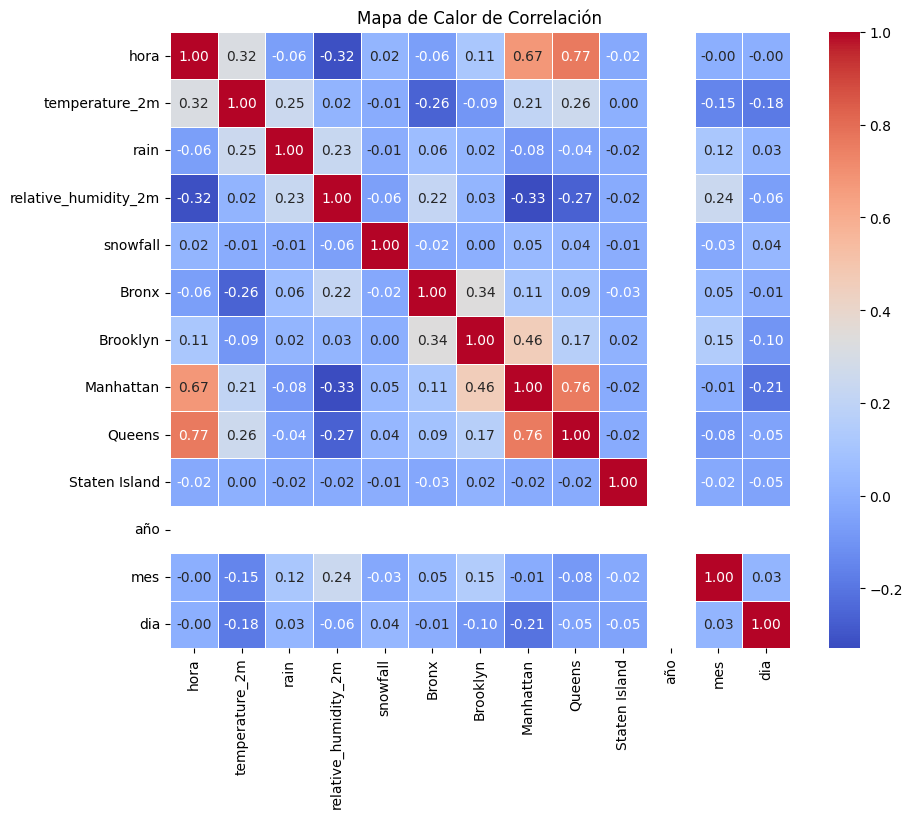

In [104]:
correlation_matrix = df.drop(columns='fecha').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor de Correlación')
plt.show()

In [105]:
df.columns

Index(['fecha', 'hora', 'temperature_2m', 'rain', 'relative_humidity_2m',
       'snowfall', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
       'año', 'mes', 'dia'],
      dtype='object')

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Dividir los datos en variables X y Y

columnas_X = ['año', 'mes', 'dia', 'hora', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]


# Normalizar los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

X_train = np.array(X_train)
X_test = np.array(X_test)

# Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Construir el modelo LSTM
model = Sequential()
#model.add(InputLayer((8,1)))
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=Y_train.shape[1]))  # Capa de salida con tantas neuronas como variables de salida
model.compile(optimizer='adam', loss='mse')  # Compilación del modelo

model.summary()
# Entrenar el modelo
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluación del modelo
loss = model.evaluate(X_test, Y_test)
print('Loss (MSE):', loss)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                11800     
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 12055 (47.09 KB)
Trainable params: 12055 (47.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 0.0961 - val_loss: 0.0417
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0264
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0329 - val_loss: 0.0406
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0286 - val_loss: 0.0354
Epoch 5/50
37/37 [====

In [107]:
df

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia
0,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1
1,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1
2,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1
3,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2023-12-31,19.0,6.2725,0.0,49.324810,0.0,8,43,4513,647,0,2023,12,31
1460,2023-12-31,20.0,6.1725,0.0,49.666042,0.0,15,48,4728,569,0,2023,12,31
1461,2023-12-31,21.0,5.6725,0.0,52.575954,0.0,36,81,4531,608,0,2023,12,31
1462,2023-12-31,22.0,4.2725,0.0,62.194458,0.0,26,90,4033,546,0,2023,12,31


In [108]:
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[2]), columns=columnas_X)
Y_test_df = pd.DataFrame(Y_test, columns=columnas_Y)
Y_predict = model.predict(X_test)
Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)
Y_test_original = scaler_Y.inverse_transform(Y_test_df)
Y_test_original_df = pd.DataFrame(Y_test_original, columns=columnas_Y)
X_test_original = scaler_X.inverse_transform(X_test_df)
X_test_original_df = pd.DataFrame(X_test_original, columns=columnas_X)
X_test_original_df['año'] = X_test_original_df['año'].astype(int)
X_test_original_df['mes'] = X_test_original_df['mes'].astype(int)
X_test_original_df['dia'] = X_test_original_df['dia'].astype(int)
X_test_original_df['fecha'] = X_test_original_df['año'].astype(str) + '-' + X_test_original_df['mes'].astype(str) + '-' + X_test_original_df['dia'].astype(str)
X_test_original_df['fecha'] = pd.to_datetime(X_test_original_df['fecha'])

10/10 [==============================] - 0s 0s/step


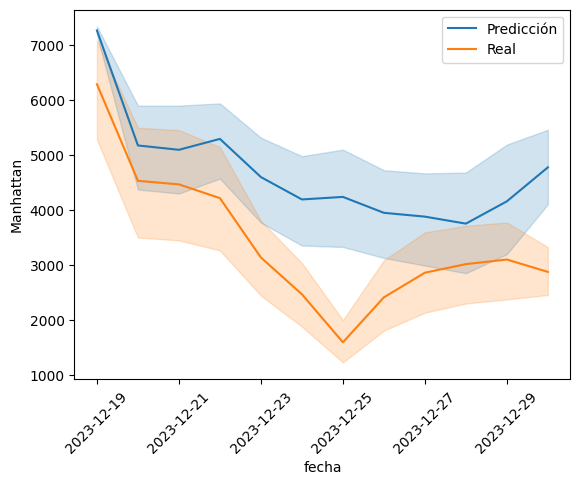

In [109]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Manhattan'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Manhattan'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Surge de manera bastante obvia la necesidad de incorporar una variable con días festivos y especiales de calendario.

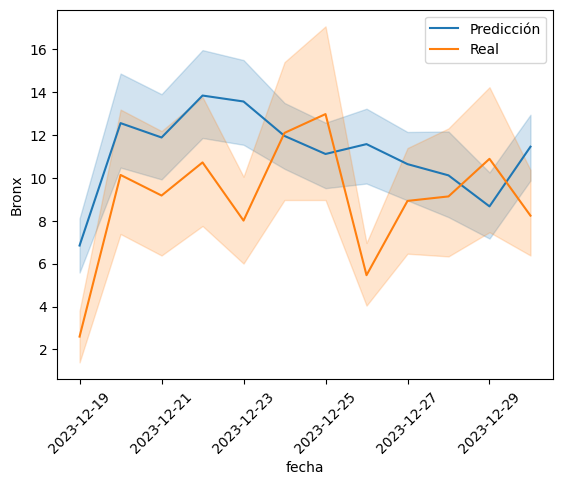

In [110]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Bronx'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Bronx'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

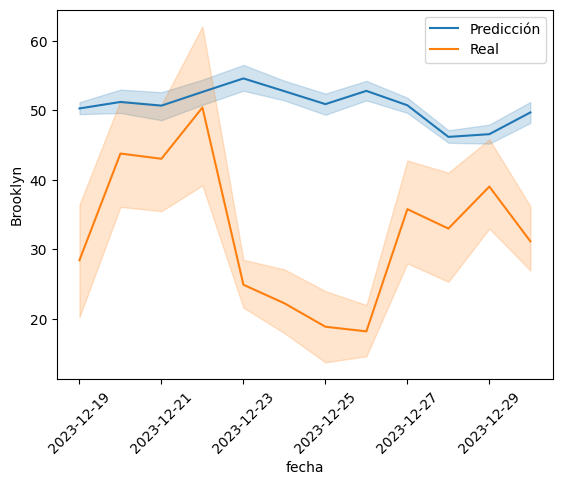

In [111]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Brooklyn'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Brooklyn'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

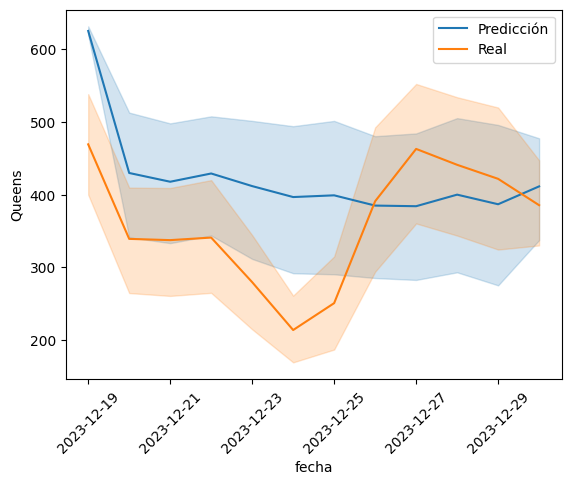

In [112]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Queens'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Queens'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

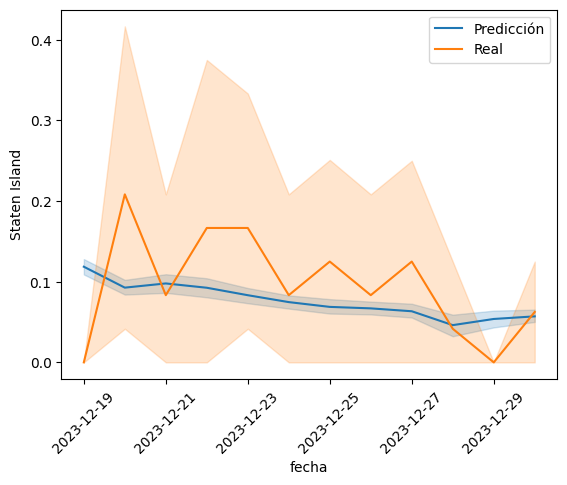

In [113]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Staten Island'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Staten Island'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [114]:
from joblib import dump

archivo = 'test_model.joblib'

dump(model, archivo)

['test_model.joblib']

In [115]:
dump(scaler_X, 'scaler_X.joblib')
dump(scaler_Y, 'scaler_Y.joblib')

['scaler_Y.joblib']

In [116]:
# Dividir los datos en variables X y Y
columnas_X = ['año', 'mes', 'dia', 'hora', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

# Normalizar los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

X_train = np.array(X_train)
X_test = np.array(X_test)

# Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Construir el modelo LSTM
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=Y_train.shape[1], activation='relu'))  # Capa de salida con tantas neuronas como variables de salida
model.compile(optimizer='adam', loss='mse')  # Compilación del modelo

model.summary()
# Entrenar el modelo
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluación del modelo
loss = model.evaluate(X_test, Y_test)
print('Loss (MSE):', loss)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11800     
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 12055 (47.09 KB)
Trainable params: 12055 (47.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 1s 8ms/step - loss: 0.0970 - val_loss: 0.0405
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0454 - val_loss: 0.0467
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0437
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0380
Epoch 5/50
37/37 [====

In [117]:
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[2]), columns=columnas_X)
Y_test_df = pd.DataFrame(Y_test, columns=columnas_Y)
Y_predict = model.predict(X_test)
Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)
Y_test_original = scaler_Y.inverse_transform(Y_test_df)
Y_test_original_df = pd.DataFrame(Y_test_original, columns=columnas_Y)
X_test_original = scaler_X.inverse_transform(X_test_df)
X_test_original_df = pd.DataFrame(X_test_original, columns=columnas_X)
X_test_original_df['año'] = X_test_original_df['año'].astype(int)
X_test_original_df['mes'] = X_test_original_df['mes'].astype(int)
X_test_original_df['dia'] = X_test_original_df['dia'].astype(int)
X_test_original_df['fecha'] = X_test_original_df['año'].astype(str) + '-' + X_test_original_df['mes'].astype(str) + '-' + X_test_original_df['dia'].astype(str)
X_test_original_df['fecha'] = pd.to_datetime(X_test_original_df['fecha'])

10/10 [==============================] - 0s 0s/step


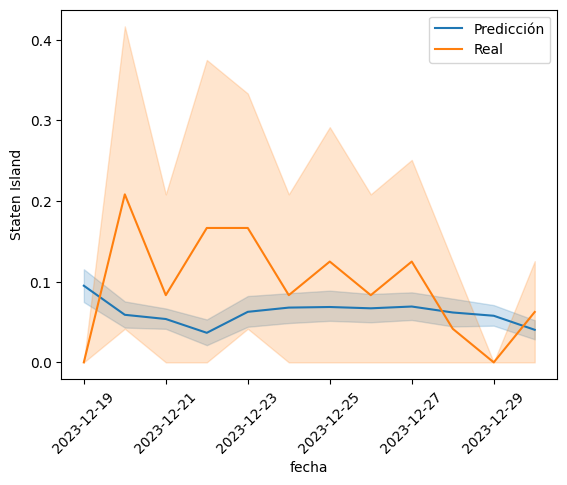

In [118]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Staten Island'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Staten Island'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

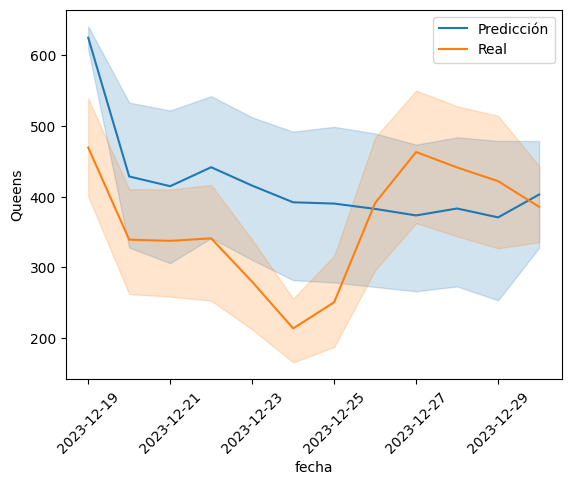

In [119]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Queens'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Queens'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

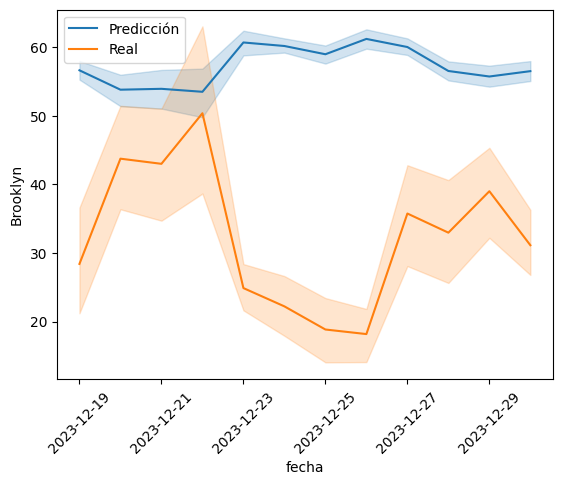

In [120]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Brooklyn'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Brooklyn'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

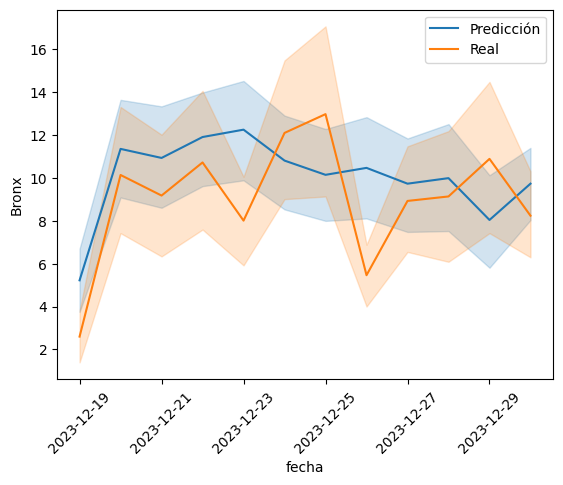

In [121]:
sns.lineplot(x=X_test_original_df['fecha'], y=Y_predict_original_df['Bronx'], label='Predicción')
sns.lineplot(x=X_test_original_df['fecha'], y=Y_test_original_df['Bronx'], label= 'Real')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Vamos a utilizar la ventaja de LSTM que es poder insertar como INPUT un tensor 3D con shape (N° de muestras, N° de pasos de tiempo, N° de features). Para ello vamos a crear primero una función que, dado el dataframe y la longitud de pasos de tiempo, retorne X e Y.

In [133]:
def generador_X_Y(X, Y, p):
    ''' 
    A partir dos dataframes, X e Y, y los pasos de tiempo, retorna un tensor 3D para X y una array 2D para Y.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - Y: pandas dataframe, con m filas (muestras) e y columnas (longitud de vector de respuesta)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n)
    - Y_reshaped: numpy array de forma (m, y)
    '''
    
    X_reshaped_list = list()
    Y_rehaped_list = list()

    m = len(X)
    X = np.array(X)
    Y = np.array(Y)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
        Y_rehaped_list.append(Y[i+p, :])
    
    X_reshaped = np.array(X_reshaped_list)
    Y_reshaped = np.array(Y_rehaped_list)

    return X_reshaped, Y_reshaped


In [125]:
X_array = np.array(X)
X_array.shape

(1464, 8)

In [126]:
X_array[0:5, :]

array([[2.02300000e+03, 1.10000000e+01, 1.00000000e+00, 0.00000000e+00,
        8.67249966e+00, 1.00000001e-01, 6.01530342e+01, 0.00000000e+00],
       [2.02300000e+03, 1.10000000e+01, 1.00000000e+00, 1.00000000e+00,
        8.57250023e+00, 0.00000000e+00, 6.03444710e+01, 0.00000000e+00],
       [2.02300000e+03, 1.10000000e+01, 1.00000000e+00, 2.00000000e+00,
        8.32250023e+00, 1.00000001e-01, 6.29331627e+01, 0.00000000e+00],
       [2.02300000e+03, 1.10000000e+01, 1.00000000e+00, 3.00000000e+00,
        8.07250023e+00, 0.00000000e+00, 6.61000214e+01, 0.00000000e+00],
       [2.02300000e+03, 1.10000000e+01, 1.00000000e+00, 4.00000000e+00,
        7.77250004e+00, 0.00000000e+00, 7.29386215e+01, 0.00000000e+00]])

In [130]:
X_reshape_prueba = list()
X_reshape_prueba.append(X_array[0:5, :])
X_reshape_prueba.append(X_array[5:10, :])
X_reshape_prueba.append(X_array[10:15, :])
X_reshape_prueba = np.array(X_reshape_prueba)

In [132]:
X_reshape_prueba.shape

(3, 5, 8)

In [134]:
X_reshaped, Y_reshaped = generador_X_Y(X, Y, 5)

In [136]:
X_reshaped.shape

(1459, 5, 8)

In [137]:
Y_reshaped.shape

(1459, 5)

Ahora vamos a probar la red neuronal con diferentes pasos de tiempo:

10/10 [==============================] - 0s 2ms/step - loss: 1119473.2500
Loss (MSE): 1119473.25 Número de pasos: 1
10/10 [==============================] - 0s 2ms/step - loss: 1099176.1250
Loss (MSE): 1099176.125 Número de pasos: 2
10/10 [==============================] - 0s 0s/step - loss: 1074397.8750
Loss (MSE): 1074397.875 Número de pasos: 3
10/10 [==============================] - 0s 379us/step - loss: 1123272.3750
Loss (MSE): 1123272.375 Número de pasos: 4
10/10 [==============================] - 0s 2ms/step - loss: 1114884.7500
Loss (MSE): 1114884.75 Número de pasos: 5
10/10 [==============================] - 0s 2ms/step - loss: 1079928.0000
Loss (MSE): 1079928.0 Número de pasos: 6
10/10 [==============================] - 0s 2ms/step - loss: 1145093.3750
Loss (MSE): 1145093.375 Número de pasos: 7
10/10 [==============================] - 0s 2ms/step - loss: 1110825.2500
Loss (MSE): 1110825.25 Número de pasos: 8
10/10 [==============================] - 0s 2ms/step - loss: 1124392

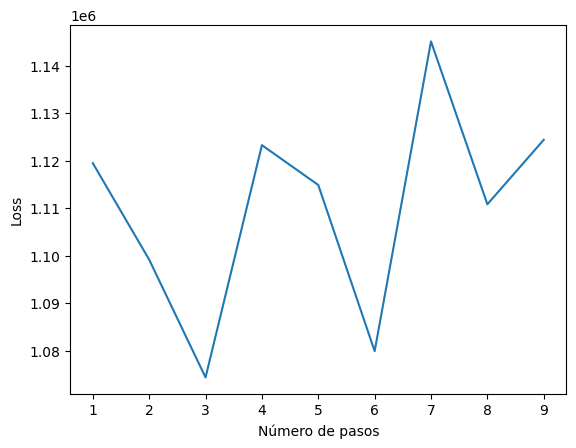

In [143]:
lista_loss = []
lista_pasos = []

# Normalizar los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

for pasos in range(1, 10):

    X_reshaped, Y_reshaped = generador_X_Y(X, Y, pasos)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, shuffle=False)

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=Y_train.shape[1]))  # Capa de salida con tantas neuronas como variables de salida
    model.compile(optimizer='adam', loss='mse')  # Compilación del modelo

    #model.summary()
    # Entrenar el modelo
    model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

    # Evaluación del modelo
    loss = model.evaluate(X_test, Y_test)
    print('Loss (MSE):', loss, 'Número de pasos:', pasos)

    
    lista_loss.append(loss)
    lista_pasos.append(pasos)

sns.lineplot(x= lista_pasos, y=lista_loss)
plt.xlabel('Número de pasos')
plt.ylabel('Loss')
plt.show()

Vemos que con número de pasos = 3 tenemos un mínimo. Generemos ese modelo y realicemos las gráficas correspondientes a las predicciones:

In [142]:
lista_loss

[824023.8125]

In [158]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

X_reshaped, Y_reshaped = generador_X_Y(X, Y, 3)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, shuffle=False)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=Y_train.shape[1], activation= 'relu'))  # Capa de salida con tantas neuronas como variables de salida
model.compile(optimizer='adam', loss='mse')  # Compilación del modelo

model.summary()
# Entrenar el modelo
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

# Evaluación del modelo
loss = model.evaluate(X_test, Y_test)

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 50)                11800     
                                                                 
 dense_40 (Dense)            (None, 5)                 255       
                                                                 
Total params: 12055 (47.09 KB)
Trainable params: 12055 (47.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
10/10 [==============================] - 0s 409us/step - loss: 1038654.1250


In [159]:
Y_test_df = pd.DataFrame(Y_test, columns=columnas_Y)
Y_predict = model.predict(X_test)
Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)

10/10 [==============================] - 0s 1ms/step


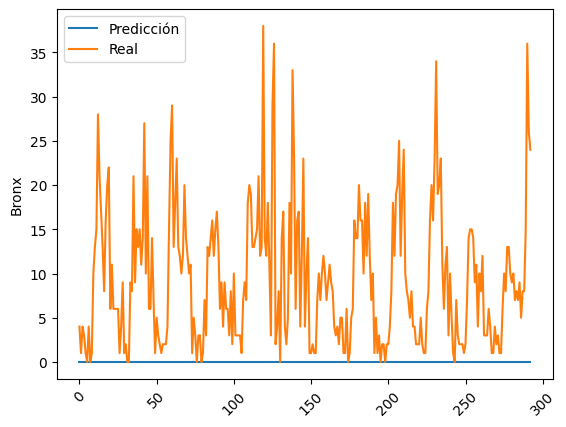

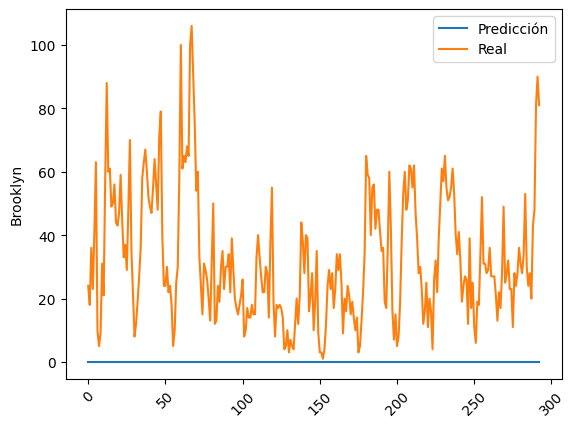

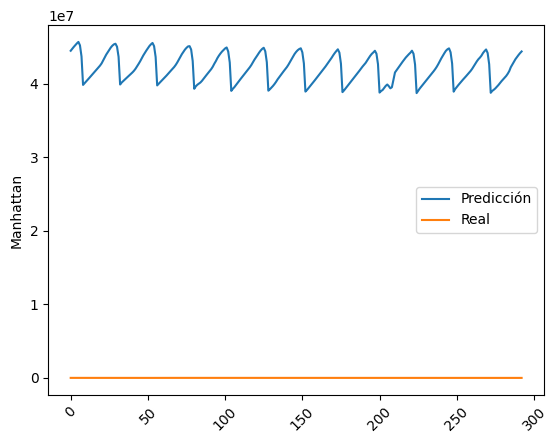

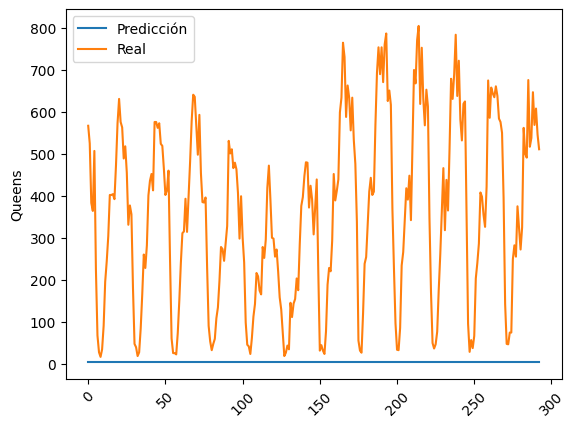

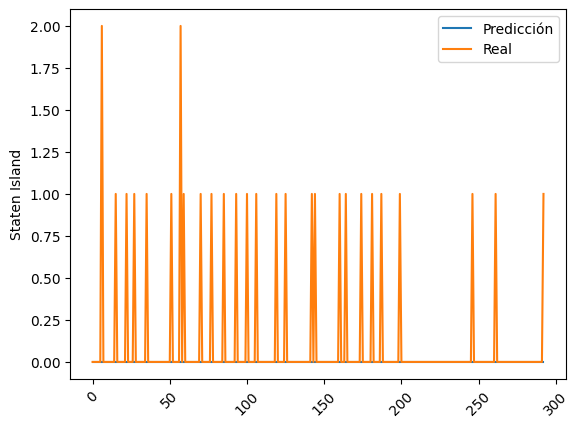

In [160]:
for i in columnas_Y:
    sns.lineplot(x=Y_predict_original_df.index, y=Y_predict_original_df[i], label='Predicción')
    sns.lineplot(x=Y_test_original_df.index, y=Y_test_original_df[i], label= 'Real')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()